# Imports and Functions

In [5]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from PIL import Image
from osgeo import gdal

import os
import glob
import random

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqi, ergas, scc, rase, sam, vifp

In [6]:
#gloabl variables
global channels 
channels = ['Coastal Aerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water Vapour','SWIR 1','SWIR 2']

In [7]:
# Functions
def get_rgb(img):
    """Return normalized RGB channels from sentinal image"""
    
    rgb_img = img[:, :, [3,2,1]]
    rgb_normalize = np.clip(rgb_img/10000, 0, 0.3)/0.3
    
    return rgb_normalize

def load_test(path):
    """Returns sentinal image, rgb image and label"""
    
    img = gdal.Open(path).ReadAsArray()
    stack_img = np.stack(img, axis=-1)
    rgb_img = get_rgb(stack_img)
    
    label_path = path.replace("images","labels").replace("image","label")
    label = gdal.Open(label_path).ReadAsArray()
    
    return stack_img, rgb_img, label

    
def channel_filter(img,c=0):
    """Returns given channel from image"""
    img = np.array(img)
    c_img = img[:, :, c]

    return c_img


def plot_channels(img,invert=False):
    
    """Plot all channels of a given image"""
    
    global channels

    fig, axs = plt.subplots(3,4,figsize=(15,10))

    index = 0
    for i in range(3):
        for j in range(4):
            c_img = channel_filter(img,c=index)
            if invert:
                c_img = 255-c_img

            axs[i,j].imshow(c_img,cmap='gray')
            axs[i,j].set_title(channels[index])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])

            index +=1

def label_to_edge(label):
    """Converts label to edge image"""
    img = label.copy()

    img = np.array(img*255)
    img = img.astype('uint8')
    img = cv2.Canny(img, 100, 200)

    img = cv2.dilate(img, np.ones((3,3), np.uint8), iterations=1)
    
    return img

# Get input and labels

In [8]:
test_path = glob.glob("../../data/SWED/test/images/*")
print(test_path[0])
print(len(test_path))

# Load all images
input = []
rgb = []
labels = []

for path in test_path:
    try:
        img, rgb_img, label = load_test(path)
    
        input.append(img)
        labels.append(label)
        rgb.append(rgb_img)
    except:
        print("Error with image: ", path)

# Apply canny to binary maps
edge_reference = [label_to_edge(img) for img in labels]

../../data/SWED/test/images/S2A_MSIL2A_20191105T023901_N0213_R089_T50RPN_20191105T062756_image_0_0.tif
98


In [9]:
#Sense checks
print("Lengths:",len(input), len(labels), len(rgb), len(edge_reference))

print("Input:", np.min(input[0]),np.max(input[0]))
print("RGB:", np.min(rgb[0]),np.max(rgb[0]))
print(len(rgb[0][0][0]))
print("Labels:",np.min(labels[0]),np.max(labels[0]))
print("Edge reference:",np.min(edge_reference),np.max(edge_reference))


Lengths: 98 98 98 98
Input: 66 8625
RGB: 0.05 1.0
3
Labels: 0 1
Edge reference: 0 255


60


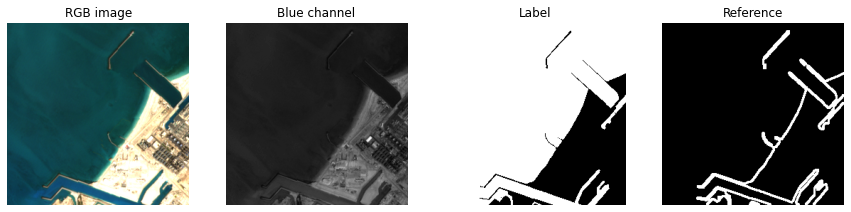

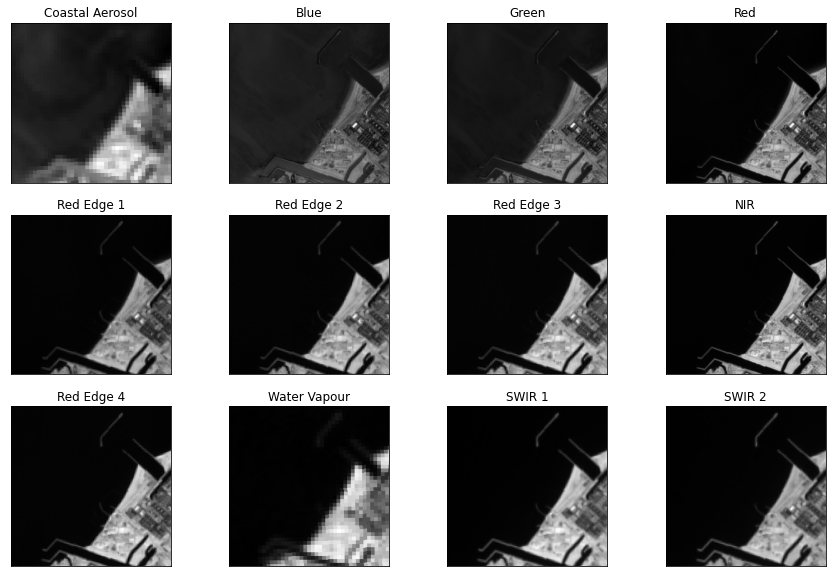

In [14]:
# View an image 
rint = random.randint(0,98)
print(rint)

fig, axs = plt.subplots(1,4, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")
axs[0].axis("off")

axs[1].imshow(input[rint][:,:,1],cmap="gray")
axs[1].set_title("Blue channel")
axs[1].axis("off")

axs[2].imshow(labels[rint],cmap="gray")
axs[2].set_title("Label")
axs[2].axis("off")

axs[3].imshow(edge_reference[rint],cmap="gray")
axs[3].set_title("Reference")
axs[3].axis("off")

plot_channels(input[rint])

# Edge detection

In [21]:
def preprocess(img_input, toggle=[True,True,True]):
        """Preprocess image for edge detection
        toggle: [Equalized histogram, Gaussian blur, Morphological closing]
        """
        img = img_input.copy()
        img = np.array(img)

        # Iterate over bands
        for i in range(12):
                img_i = img[:,:,i]

                # Scale bands between 0 and 255
                img[:,:,i] = cv2.normalize(img[:,:,i], None, 0, 255, cv2.NORM_MINMAX)

                # Equalized histogram
                img_i = np.uint8(img_i)
                if toggle[0]:
                        img_i = cv2.equalizeHist(img_i)


                # Gaussian blur
                if toggle[1]:
                        kernel = (5, 5)
                        img_i = cv2.GaussianBlur(img_i, kernel,0)

                # Morphological closing
                if toggle[2]:
                        kernel = np.ones((5,5),np.uint8)
                        img_i = cv2.morphologyEx(img_i, cv2.MORPH_CLOSE, kernel)
                
                img[:,:,i] = img_i
       
        img = np.uint8(img)
        return img

33
254 7120


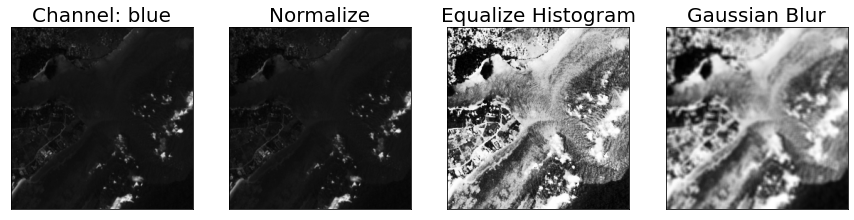

In [16]:
rint = random.randint(0,98)
fig, axs = plt.subplots(1,4, figsize=(15,15))
print(rint)

img = channel_filter(input[rint],c=2)
#img = np.uint8(img)
print(np.min(img),np.max(img))

axs[0].imshow(img,cmap="gray")
axs[0].set_title("Channel: blue",size=20)

#img = np.uint8(img)

# Scale bands between 0 and 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
axs[1].imshow(img,cmap="gray")
axs[1].set_title("Normalize",size=20)

img = np.uint8(img)

img = cv2.equalizeHist(img)
axs[2].imshow(img,cmap="gray")
axs[2].set_title("Equalize Histogram",size=20)

# Gaussian Blur
kernel = (5,5)
img = cv2.GaussianBlur(img, kernel,cv2.BORDER_DEFAULT)
axs[3].imshow(img,cmap="gray")
axs[3].set_title("Gaussian Blur",size=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [22]:
def canny_ed(img_input, threshold1=100, threshold2=200):

    #Apply canny edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        img_i = cv2.Canny(img_i,threshold1 = threshold1, threshold2 = threshold2)
        img[:,:,i] = img_i

    return img


def scharr_ed(img_input):
    #Apply scharr edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        schx = cv2.Scharr(img_i, cv2.CV_8U,1,0)
        schy = cv2.Scharr(img_i, cv2.CV_8U,0,1)
        scharr_img = schx + schy

        img[:,:,i] = scharr_img

    return img

def sobel_ed(img_input):
    #Apply sobel edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        sobelx = cv2.Sobel(img_i, cv2.CV_8U,1,0,ksize=5)
        sobely = cv2.Sobel(img_i, cv2.CV_8U,0,1,ksize=5)
        sobel_img = sobelx + sobely

        img[:,:,i] = sobel_img

    return img    

def prewitt_ed(img_input):
    #Apply prewitt edge detection to image
    img = img_input.copy()
    img = np.array(img)

    for i in range(12):
        img_i = img[:,:,i]
        kx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]]) 
        ky = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
        prewittx = cv2.filter2D(img_i, -1, kx)
        prewitty = cv2.filter2D(img_i, -1, ky)
        prewitt_img = prewittx + prewitty

        img[:,:,i] = prewitt_img

    return img

40


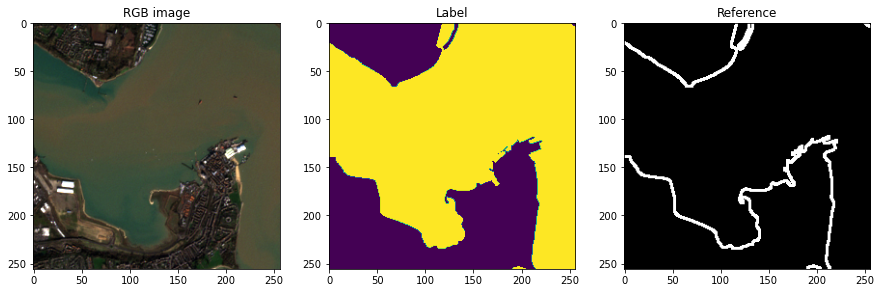

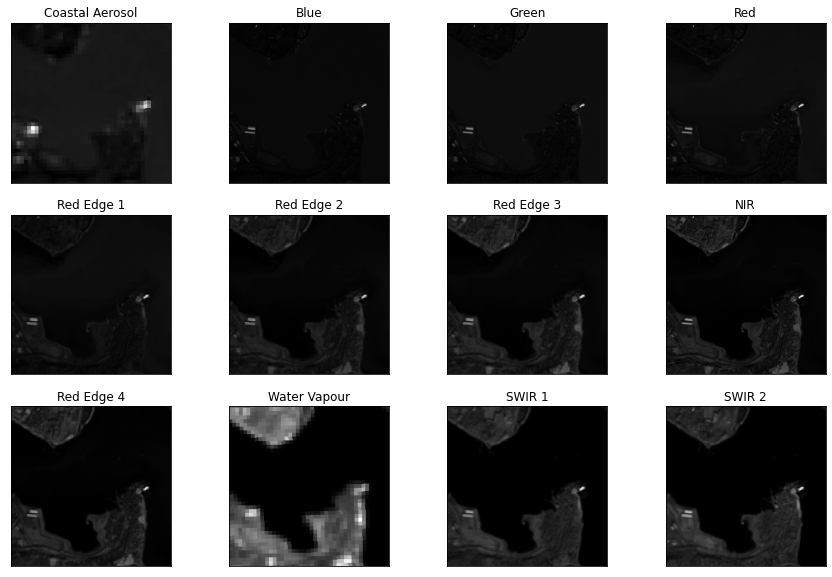

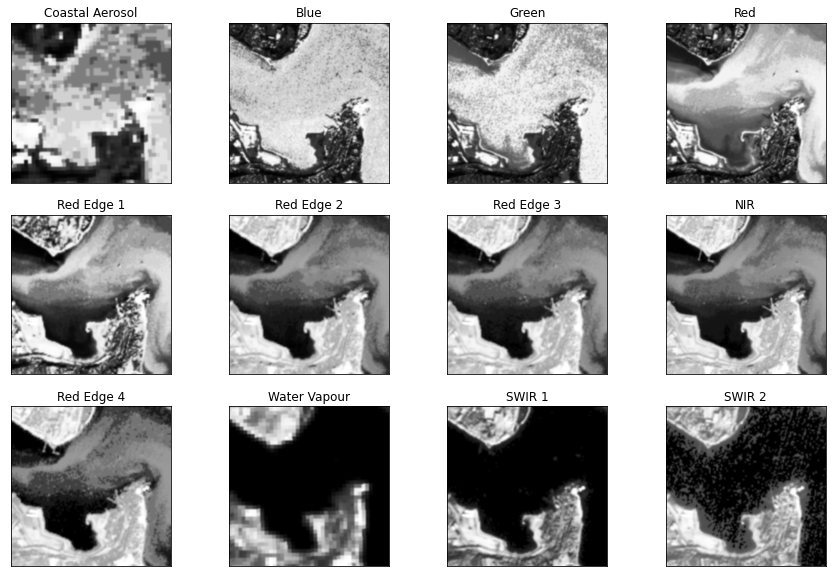

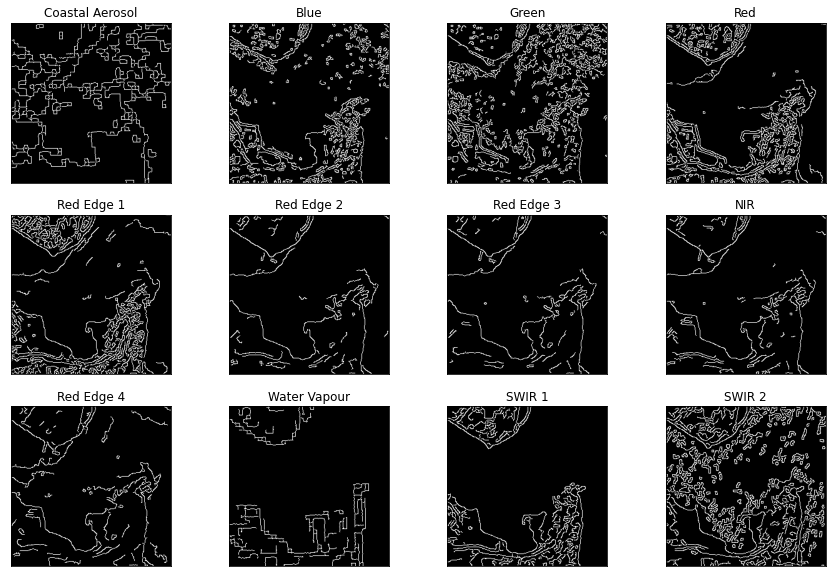

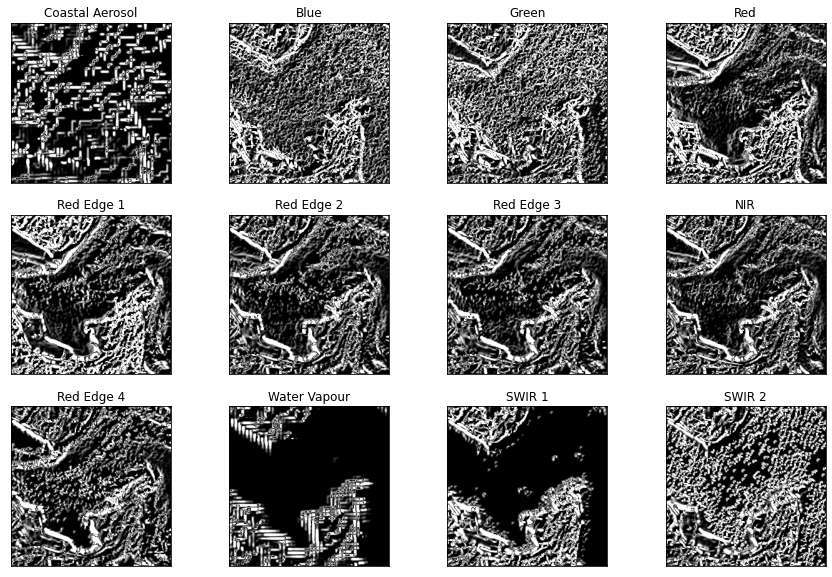

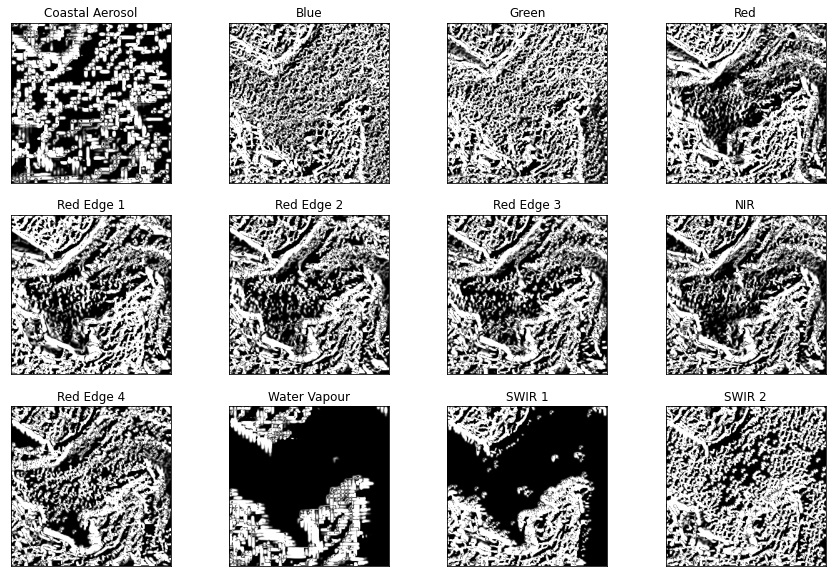

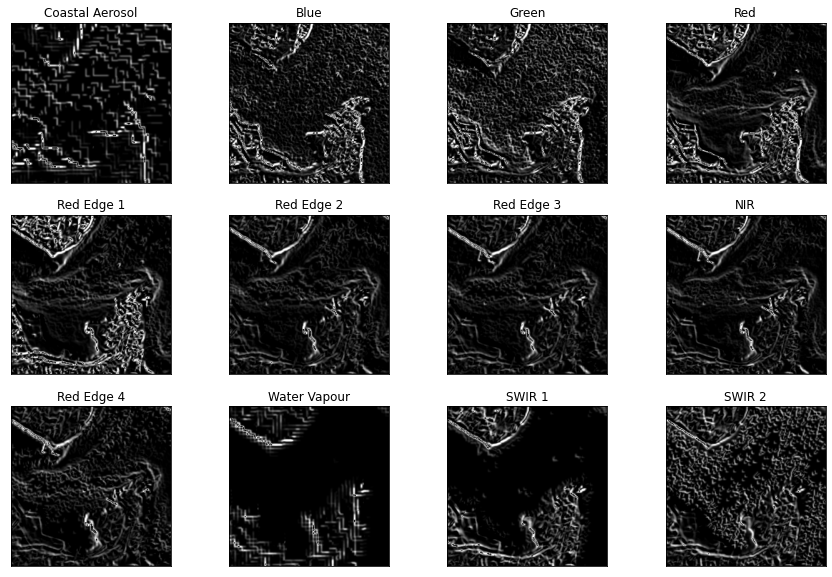

In [18]:
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

canny = [canny_ed(img) for img in preprocess_input]
scharr = [scharr_ed(img) for img in preprocess_input]
sobel = [sobel_ed(img) for img in preprocess_input]
prewitt = [prewitt_ed(img) for img in preprocess_input]

rint = random.randint(0,98)
print(rint)
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint])
axs[1].set_title("Label")

axs[2].imshow(edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")

plot_channels(input[rint])

plot_channels(preprocess_input[rint])

plot_channels(canny[rint])

plot_channels(scharr[rint])

plot_channels(sobel[rint])

plot_channels(prewitt[rint])

86
0.0 255.0
0.0 255.0
0.0 255.0
-255.0 0.0


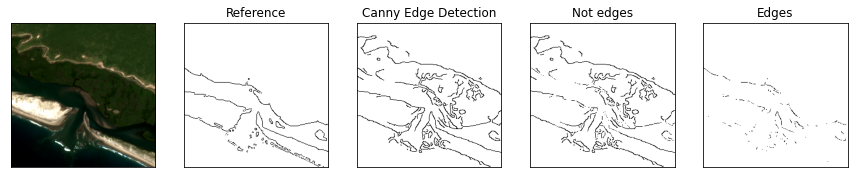

In [298]:
rint = random.randint(0,98)
print(rint)


preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]


r = edge_reference[rint]*1.0
print(r.min(),r.max())

c = 2
canny = [canny_ed(img) for img in preprocess_input][rint][:,:,c]*1.0
print(canny.min(),canny.max())

non_edge =  np.array(canny)-np.array(r)
non_edge = np.clip(non_edge,0,255)
print(non_edge.min(),non_edge.max())

edge = np.clip(non_edge,0,255)-np.array(canny)
print(edge.min(),edge.max())

fig, axs = plt.subplots(1,5, figsize=(15,15))

axs[0].imshow(rgb[rint])

axs[1].imshow(255-r,cmap="gray")
axs[1].set_title("Reference")
axs[2].imshow(255-canny,cmap="gray")
axs[2].set_title("Canny Edge Detection")
axs[3].imshow(255-non_edge,cmap="gray")
axs[3].set_title("Not edges")
axs[4].imshow(edge,cmap="gray")
axs[4].set_title("Edges")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


96


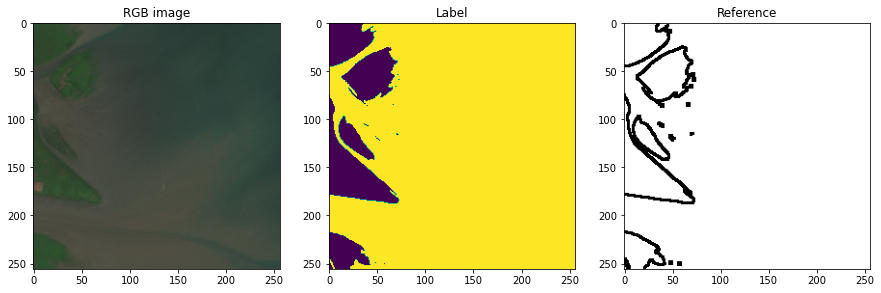

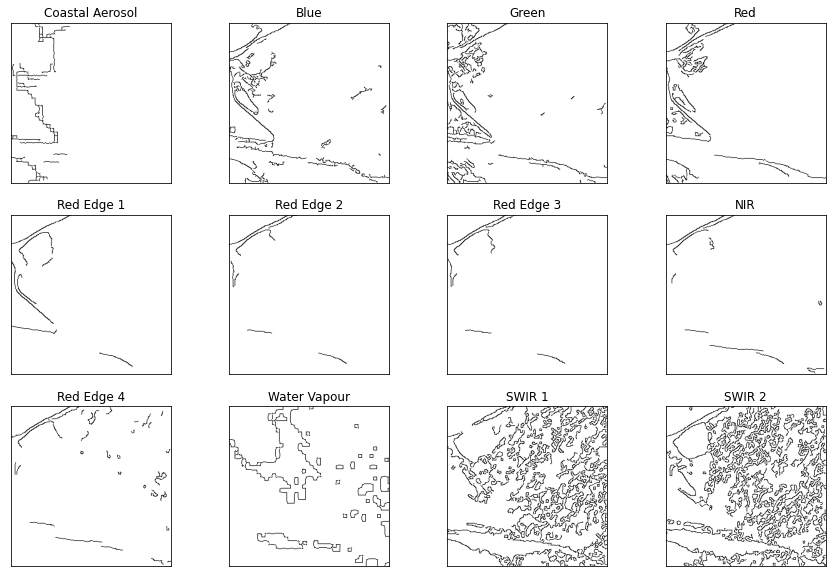

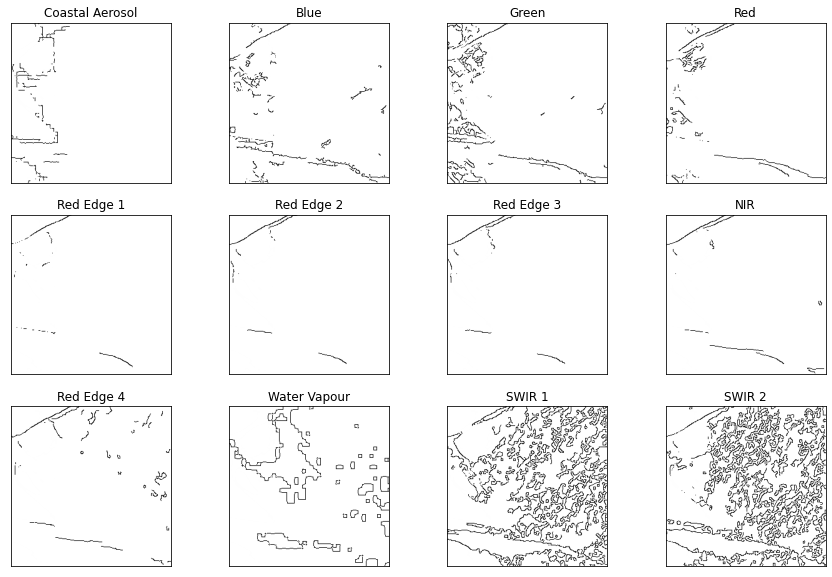

In [23]:
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

canny = [canny_ed(img) for img in preprocess_input]

rint = random.randint(0,98)
print(rint)
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint])
axs[1].set_title("Label")

axs[2].imshow(255-edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")

plot_channels(canny[rint],invert=True)

overlap = np.zeros((256,256,12))
for i in range(12):
    overlap[:,:,i] = canny[rint][:,:,i] - edge_reference[rint]

plot_channels(overlap,invert=True)


In [173]:
overlap.min(), overlap.max() 

(0.0, 255.0)

# Metrics

In [24]:
def metrics(toggle=[True,True,False]):
    """Calculate metrics
    toggle: [Equalized histogram, Gaussian blur, Morphological closing]"""

    preprocess_input = input.copy()
    preprocess_input = [preprocess(img,toggle=toggle) for img in preprocess_input]

    canny = [canny_ed(img) for img in preprocess_input]
    scharr = [scharr_ed(img) for img in preprocess_input]
    sobel = [sobel_ed(img) for img in preprocess_input]
    prewitt = [prewitt_ed(img) for img in preprocess_input]

    rows = []
    for i in range(len(edge_reference)):
        ref_img = edge_reference[i]
        ID = "IMG#{}".format(i)
        
        for j in range(12):

            for method in ['canny','sobel','scharr','prewitt']:

                if method == 'canny':
                    img = canny[i][:,:,j]
                elif method == 'sobel':
                    img = sobel[i][:,:,j]
                elif method == 'scharr':
                    img = scharr[i][:,:,j]
                elif method == 'prewitt':
                    img = prewitt[i][:,:,j]

                rmse_ = rmse(ref_img,img)
                psnr_ = psnr(ref_img,img)
                uqi_ = uqi(ref_img,img)
                ssim_ = ssim(ref_img,img,multichannel=True)
                ergas_ = ergas(ref_img,img)
                scc_ = scc(ref_img,img)
                sam_ = sam(ref_img,img)
                vifp_ = vifp(ref_img,img)

                row = [ID,j+1,method,rmse_,psnr_,uqi_,ssim_,ergas_,scc_,sam_,vifp_]
                rows.append(row)
        
    df_metrics = pd.DataFrame(rows,columns = ['ID',"band","method","rmse","psnr","uqi","ssim","ergas","scc","sam","vifp"])
    return df_metrics

In [25]:
# With equalized histogram, Gaussian blur
df_metrics = metrics()
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_2.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_42068/211791014.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)
/Users/conorosullivan/opt/miniconda3/envs/pytorch/lib/python3.10/site-packages/sewar/full_ref.py:270: RuntimeWarning: invalid value encountered in double_scalars
  val = np.clip(np.dot(GT[:,i],P[:,i]) / (np.linalg.norm(GT[:,i])*np.linalg.norm(P[:,i])),-1,1)


ID  band   method        rmse      psnr       uqi      ssim  \
0  IMG#0     1    canny   88.473089  9.194580  0.582898  0.722917   
1  IMG#0     1    sobel  155.592041  4.291056  0.111096  0.155402   
2  IMG#0     1   scharr  112.389480  7.116290  0.102125  0.194299   
3  IMG#0     1  prewitt   82.475731  9.804280  0.057575  0.272174   
4  IMG#0     2    canny  110.197866  7.287340  0.341087  0.493078   

          ergas       scc       sam      vifp  
0  16078.890835  0.001942  1.437358  0.011495  
1  26665.350175  0.003207  1.326258  0.009850  
2  19519.499517 -0.000135  1.352271  0.010136  
3  14981.989566  0.003092  1.382482  0.011455  
4  18090.799621  0.006540  1.363461  0.024429

In [334]:
# With equalized histogram, Morphological closing
df_metrics = metrics(toggle=[True,False,True])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/4050410403.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   78.286885  10.257023  0.444999  0.632948   
1  IMG#0     1    sobel  147.054056   4.781263  0.088116  0.246596   
2  IMG#0     1   scharr  103.471134   7.834419  0.122093  0.365272   
3  IMG#0     1  prewitt   61.374303  12.371072  0.093555  0.385970   
4  IMG#0     2    canny   80.184000  10.049049  0.425889  0.636895   

          ergas       scc       sam      vifp  
0  26399.071577  0.000255  1.494533  0.010702  
1  40682.576640  0.001299  1.456060  0.006613  
2  30328.993795 -0.001436  1.485564  0.006651  
3  21775.060833 -0.001278  1.488072  0.008312  
4  24738.362800  0.011679  1.406753  0.035201

In [335]:
# With equalized histogram
df_metrics = metrics(toggle=[True,False,False])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/4050410403.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   78.829981  10.196975  0.442986  0.629021   
1  IMG#0     1    sobel  147.485521   4.755816  0.087121  0.244223   
2  IMG#0     1   scharr  103.898240   7.798640  0.119916  0.362653   
3  IMG#0     1  prewitt   61.508375  12.352119  0.088245  0.379766   
4  IMG#0     2    canny  120.193478   6.533186  0.190313  0.341794   

          ergas       scc       sam      vifp  
0  26765.284653  0.000463  1.492990  0.010928  
1  40777.945583  0.002370  1.455997  0.006744  
2  30477.751751 -0.001305  1.484598  0.006823  
3  21831.701325 -0.001043  1.487631  0.008333  
4  31953.298014  0.023167  1.417124  0.029726

In [336]:
# With gaussian blur
df_metrics = metrics(toggle=[False,True,False])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur.csv")
df_metrics.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_84017/4050410403.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


ID  band   method        rmse       psnr       uqi      ssim  \
0  IMG#0     1    canny   48.277161  14.455969  0.736069  0.851022   
1  IMG#0     1    sobel  126.553173   6.085343  0.068628  0.186666   
2  IMG#0     1   scharr   83.056050   9.743378  0.083111  0.256971   
3  IMG#0     1  prewitt   46.352833  14.809278  0.051093  0.416612   
4  IMG#0     2    canny   48.256604  14.459668  0.735006  0.852225   

          ergas       scc       sam      vifp  
0  19456.218528  0.000904  1.552568  0.000829  
1  34414.622144  0.000069  1.451816  0.007570  
2  24514.757680 -0.000421  1.480485  0.006798  
3  18397.852162  0.001301  1.496469  0.007490  
4  18876.509366  0.002060  1.546719  0.000148

## Thresholds and preproccessing experiments

In [13]:
thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
#toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]
toggles = [[True,True,False]]

rows = []

for toggle in toggles:
    print(toggle)
    preprocess_input = input.copy()
    preprocess_input = [preprocess(img,toggle=toggle) for img in preprocess_input]

    for threshold in thresholds:
        print(threshold)

        t1 = threshold[0]
        t2 = threshold[1]
        canny = [canny_ed(img,threshold1=t1,threshold2=t2) for img in preprocess_input]
        
        for i in range(len(edge_reference)):
            ref_img = edge_reference[i]
            ID = "IMG#{}".format(i)
            
            for j in range(12):
                
                img = canny[i][:,:,j]

                rmse_ = rmse(ref_img,img)
                psnr_ = psnr(ref_img,img)
                uqi_ = uqi(ref_img,img)
                ssim_ = ssim(ref_img,img,multichannel=True)
                """ergas_ = ergas(ref_img,img)
                scc_ = scc(ref_img,img)
                sam_ = sam(ref_img,img)
                vifp_ = vifp(ref_img,img)"""

                row = [ID,str(threshold),str(toggle),j+ 1,rmse_,psnr_,uqi_,ssim_]
                rows.append(row)

    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","toggle","band","rmse","psnr","uqi","ssim"])
df_metrics.to_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_canny.csv")
df_metrics.head()

[True, True, False]
[50, 100]


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_39229/1566429233.py:30: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_ = ssim(ref_img,img,multichannel=True)


[50, 150]
[100, 200]
[100, 300]
[200, 400]
[200, 600]


ID thresholds               toggle  band        rmse       psnr  \
0  IMG#0  [50, 100]  [True, True, False]     1   79.550419  10.117954   
1  IMG#0  [50, 100]  [True, True, False]     2  114.129916   6.982814   
2  IMG#0  [50, 100]  [True, True, False]     3  114.611397   6.946247   
3  IMG#0  [50, 100]  [True, True, False]     4  108.496514   7.422488   
4  IMG#0  [50, 100]  [True, True, False]     5  103.166656   7.860017   

        uqi      ssim  
0  0.423946  0.621664  
1  0.205812  0.363762  
2  0.212721  0.363408  
3  0.278936  0.429085  
4  0.306143  0.454464

# Visualise metrics

In [27]:
def metric_bar(df,metric,save=False):
    """Plot bar chart of given metric for each edge detection method and band"""
    global channels 

    fig,ax = plt.subplots(1,1,figsize=(15,5))

    mean = df.groupby(["method","band"],as_index=False).mean()
    sd = df.groupby(["method","band"],as_index=False).std()

    edge_methods = ["canny","sobel","scharr","prewitt"]
    for i,em in enumerate(edge_methods):

        bands = mean[mean["method"]==em]["band"]
        em_mean = mean[mean["method"]==em][metric]
        em_sd = sd[sd["method"]==em][metric]

        w = 0.4
        plt.bar(bands-w/2+i*w/2,em_mean,yerr=em_sd,width=w/2,label=em)


    plt.ylabel(metric.upper(),fontsize=20)
    plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

    plt.legend()
    if save:
        plt.savefig("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/figures/{}_BAR.png".format(metric),bbox_inches='tight')

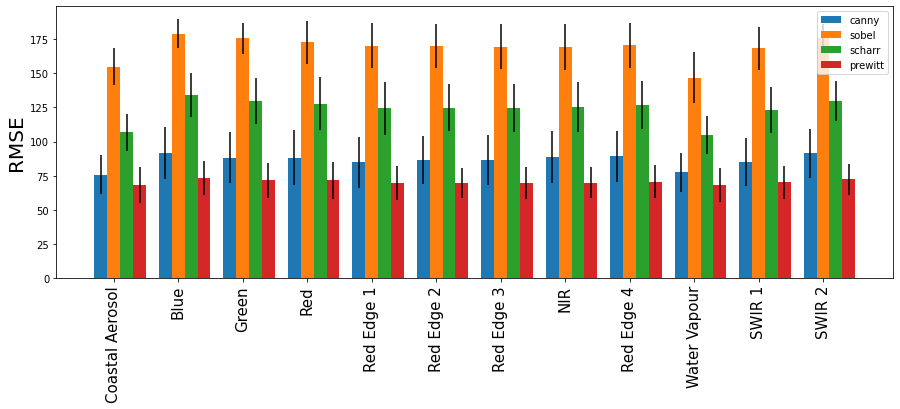

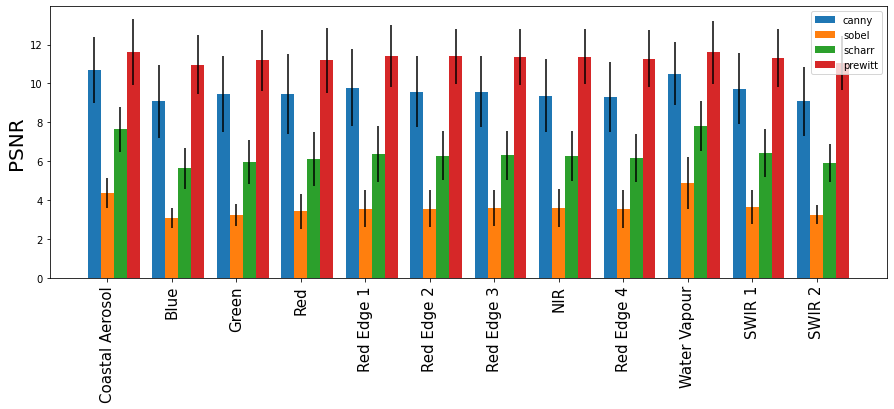

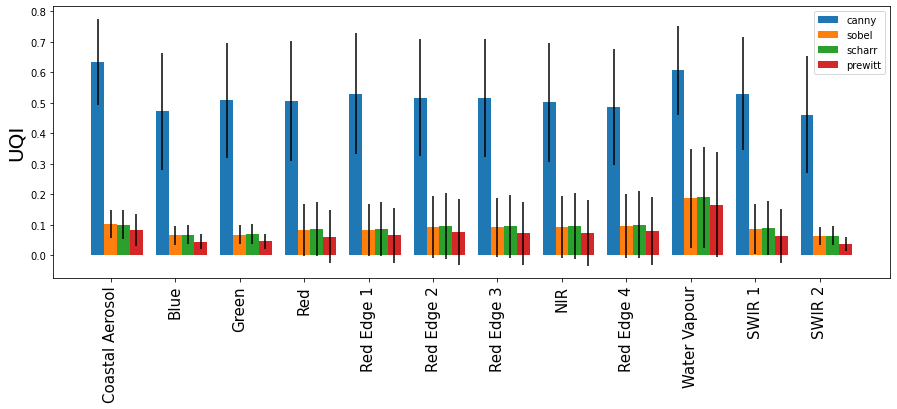

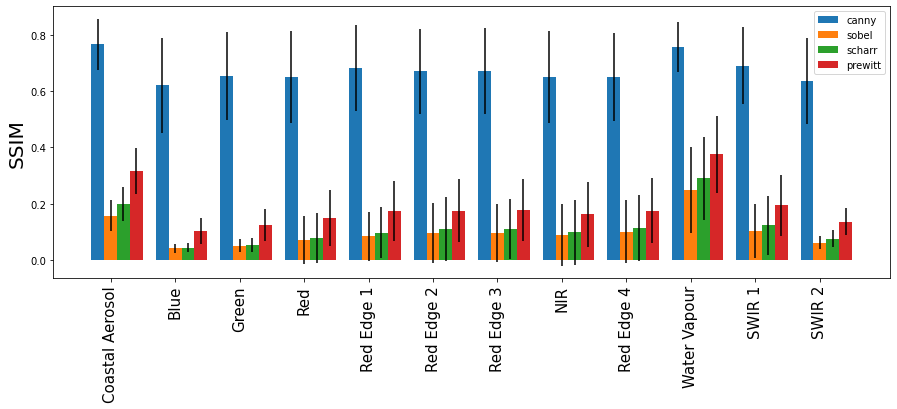

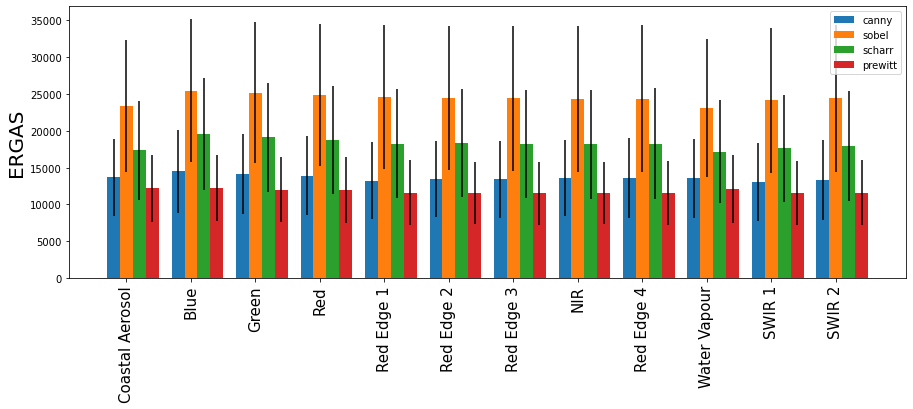

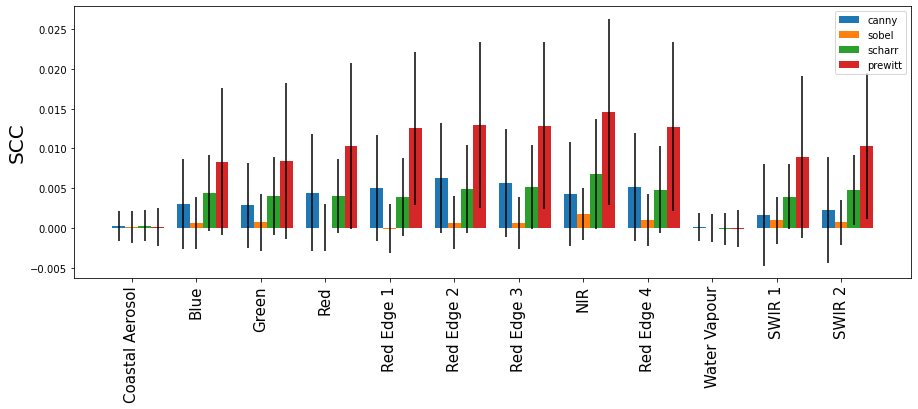

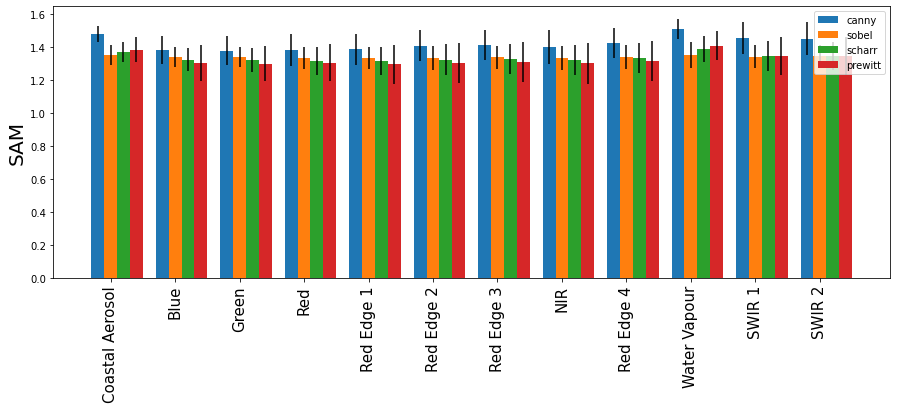

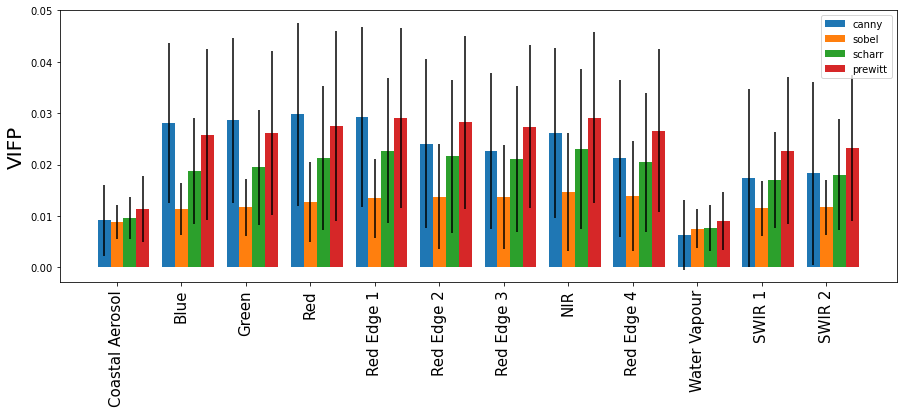

In [28]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all_2.csv",index_col=0)

metric_bar(df_metrics,'rmse',save=True)
metric_bar(df_metrics,'psnr',save=True)
metric_bar(df_metrics,'uqi')
metric_bar(df_metrics,'ssim',save=True)
metric_bar(df_metrics,'ergas')
metric_bar(df_metrics,'scc')
metric_bar(df_metrics,'sam',save=True)
metric_bar(df_metrics,'vifp')

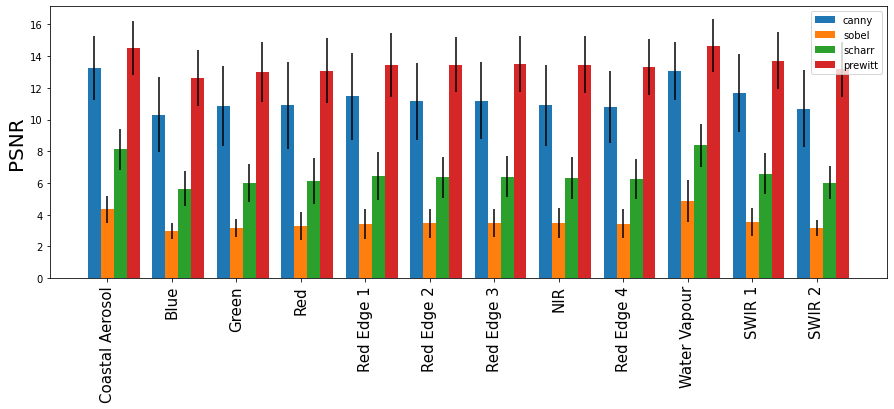

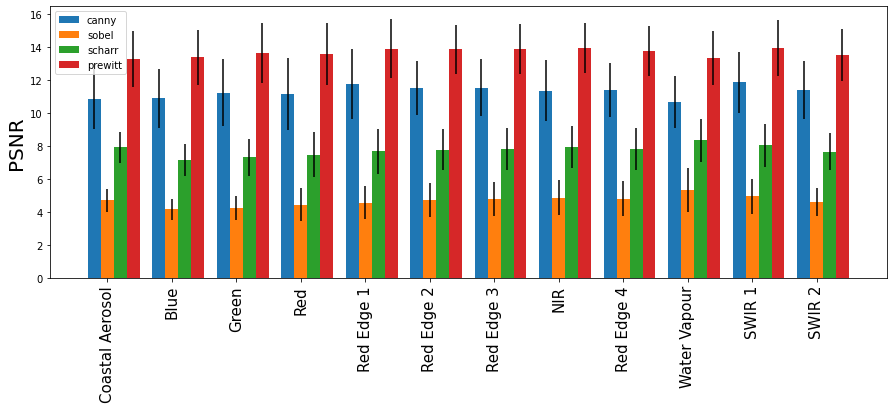

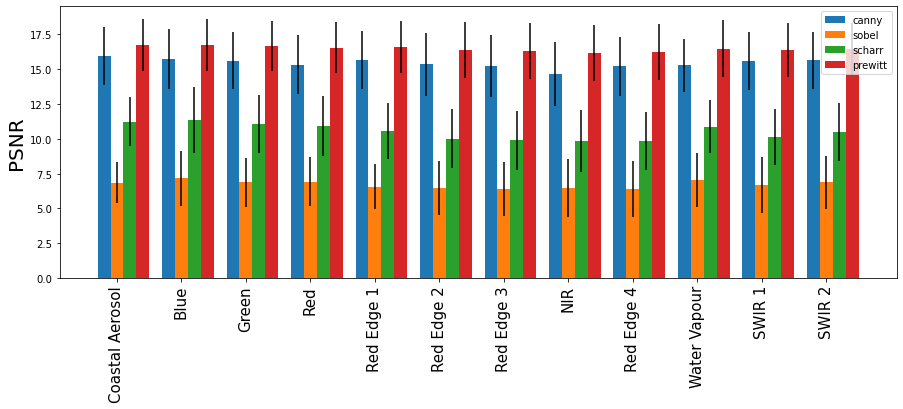

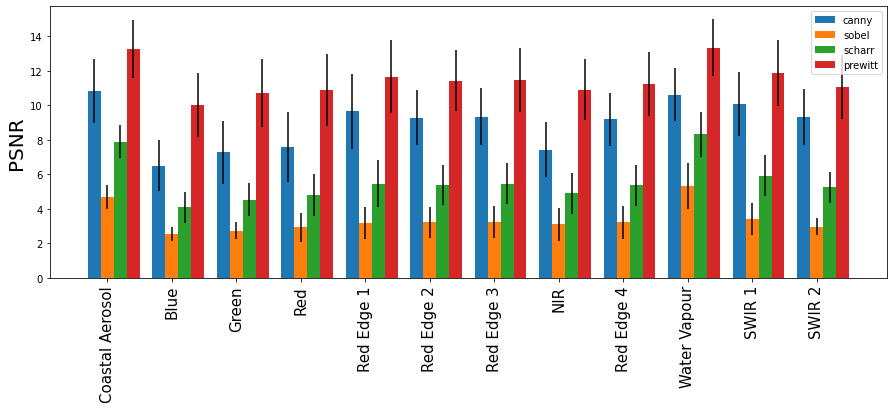

In [443]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur.csv",index_col=0)
metric_bar(df_metrics,'psnr')

df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv",index_col=0)
metric_bar(df_metrics,'psnr')


In [14]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_canny.csv",index_col=0)
df_metrics.head()

ID thresholds               toggle  band        rmse       psnr  \
0  IMG#0  [50, 100]  [True, True, False]     1   79.550419  10.117954   
1  IMG#0  [50, 100]  [True, True, False]     2  114.129916   6.982814   
2  IMG#0  [50, 100]  [True, True, False]     3  114.611397   6.946247   
3  IMG#0  [50, 100]  [True, True, False]     4  108.496514   7.422488   
4  IMG#0  [50, 100]  [True, True, False]     5  103.166656   7.860017   

        uqi      ssim  
0  0.423946  0.621664  
1  0.205812  0.363762  
2  0.212721  0.363408  
3  0.278936  0.429085  
4  0.306143  0.454464

In [15]:
set(df_metrics.toggle)
set(df_metrics.thresholds)

{'[100, 200]',
 '[100, 300]',
 '[200, 400]',
 '[200, 600]',
 '[50, 100]',
 '[50, 150]'}

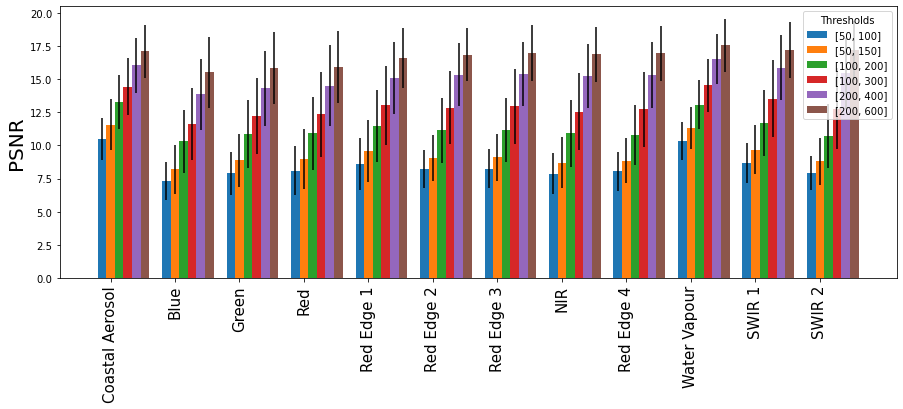

In [17]:
mean =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).mean()
sd =  df_metrics[df_metrics.toggle=="[True, True, False]"].groupby(["thresholds","band"],as_index=False).std()
metric = "psnr"
global channels

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]]
toggles = [[True,False,False],[True,True,False],[True,False,True],[True,True,True]]


fig,ax = plt.subplots(1,1,figsize=(15,5))

w = 0.4
for i,thresh in enumerate(thresholds):

    bands = mean[mean.thresholds==str(thresh)]["band"]

    mean_i = mean[mean.thresholds==str(thresh)][metric]
    sd_i = sd[sd.thresholds==str(thresh)][metric]
    
    plt.bar(bands-w/3+i*w/3,mean_i,yerr=sd_i,width=w/3,label=str(thresh))

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend(title="Thresholds")


1


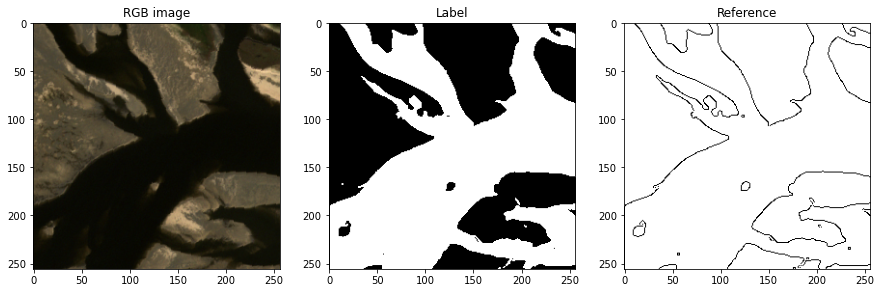

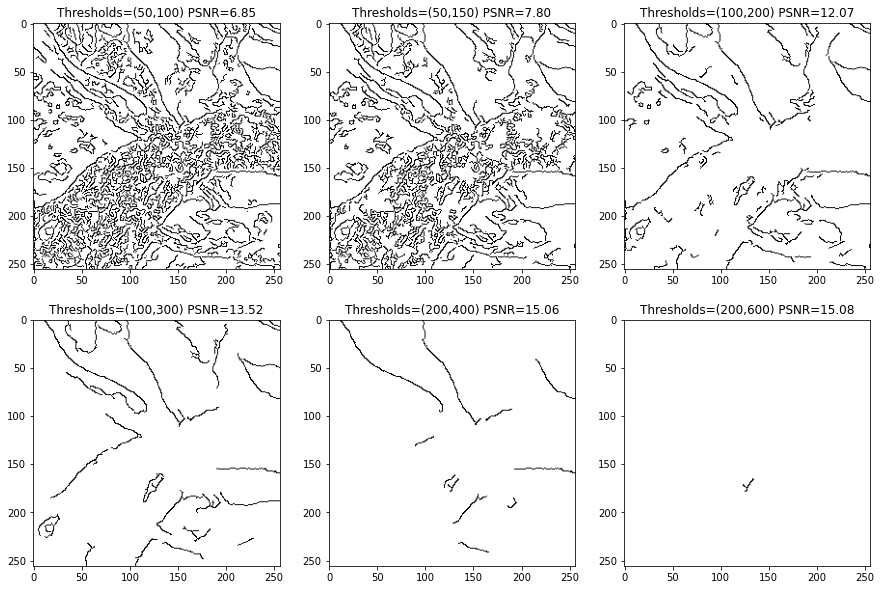

In [273]:
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

rint = random.randint(0,98)
print(rint)
rint=48
fig, axs = plt.subplots(1,3, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB image")

axs[1].imshow(labels[rint],cmap="gray")
axs[1].set_title("Label")

axs[2].imshow(255-edge_reference[rint],cmap="gray")
axs[2].set_title("Reference")


fig,axs = plt.subplots(2,3,figsize=(15,10))

for i,ax in enumerate(axs.flatten()):
    t1 = thresholds[i][0]
    t2 = thresholds[i][1]
    canny = [canny_ed(img,t1,t2) for img in preprocess_input][rint][:,:,1]
    psnr_ = psnr(edge_reference[rint],canny)
    ax.imshow(255-canny,cmap="gray")
    ax.set_title("Thresholds=({},{}) PSNR={:.2f}".format(t1,t2,psnr_))



In [130]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)
df_metrics[df_metrics.method=="canny"].groupby(["band"],as_index=False).mean()

band       rmse       psnr       uqi      ssim         ergas       scc  \
0      1  56.945754  13.244265  0.648188  0.794515  18062.041657  0.000229   
1      2  80.726080  10.300526  0.478187  0.640311  20548.322919  0.008997   
2      3  76.175927  10.846287  0.516523  0.673816  19979.099748  0.008873   
3      4  76.156996  10.902086  0.515102  0.670535  19650.455720  0.008397   
4      5  71.299897  11.472044  0.542107  0.702909  18682.585858  0.005601   
5      6  73.445009  11.138447  0.523979  0.689976  19224.815840 -0.000055   
6      7  73.173187  11.175203  0.525430  0.691833  19058.507299  0.000137   
7      8  75.828928  10.894756  0.514198  0.672241  18945.051506  0.007629   
8      9  76.223625  10.778996  0.494850  0.669727  19314.550445  0.000035   
9     10  57.857382  13.067306  0.622987  0.787109  17362.046532  0.000508   
10    11  69.159694  11.669945  0.546376  0.717056  17654.647994  0.002267   
11    12  77.289853  10.687008  0.475980  0.661572  18124.788090  0.002430   

         sam      vifp  
0   1.521831  0.009703  
1   1.438808  0.036319  
2   1.435520  0.036550  
3   1.436556  0.038442  
4   1.447871  0.037217  
5   1.477673  0.027580  
6   1.479964  0.025921  
7   1.453653  0.032890  
8   1.487773  0.024585  
9   1.536895  0.006823  
10  1.499296  0.021770  
11  1.496503  0.023129

In [133]:
df_metrics = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_canny.csv",index_col=0)
df_metrics[(df_metrics.toggle=="[True, True, False]") & (df_metrics.thresholds=="[100, 200]")].groupby(["band"],as_index=False).mean()


band       rmse       psnr       uqi      ssim
0      1  56.945754  13.244265  0.648188  0.794515
1      2  80.726080  10.300526  0.478187  0.640311
2      3  76.175927  10.846287  0.516523  0.673816
3      4  76.156996  10.902086  0.515102  0.670535
4      5  71.299897  11.472044  0.542107  0.702909
5      6  73.445009  11.138447  0.523979  0.689976
6      7  73.173187  11.175203  0.525430  0.691833
7      8  75.828928  10.894756  0.514198  0.672241
8      9  76.223625  10.778996  0.494850  0.669727
9     10  57.857382  13.067306  0.622987  0.787109
10    11  69.159694  11.669945  0.546376  0.717056
11    12  77.289853  10.687008  0.475980  0.661572

# Figures for paper 

In [73]:
save_path = "/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/figures/{}"

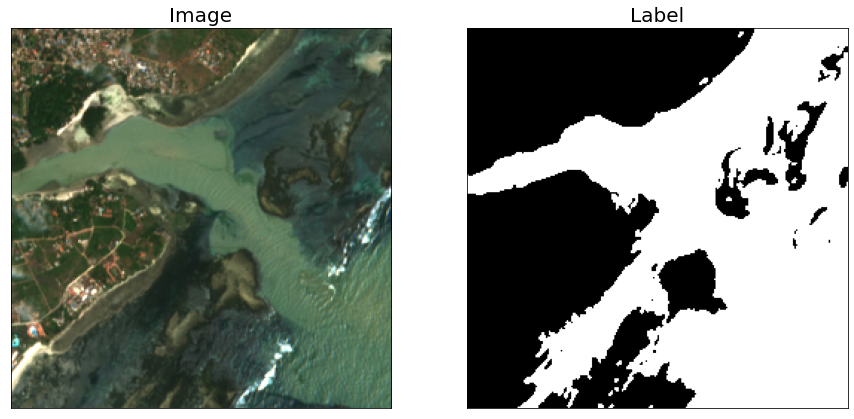

In [74]:
rint = 90
fig, axs = plt.subplots(1,2, figsize=(15,15))

axs[0].imshow(rgb[rint])
axs[0].set_title("Image",size=20)


axs[1].imshow(labels[rint],cmap="gray")
axs[1].set_title("Label",size=20)
rint +=1

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("text_example"),bbox_inches='tight')

26


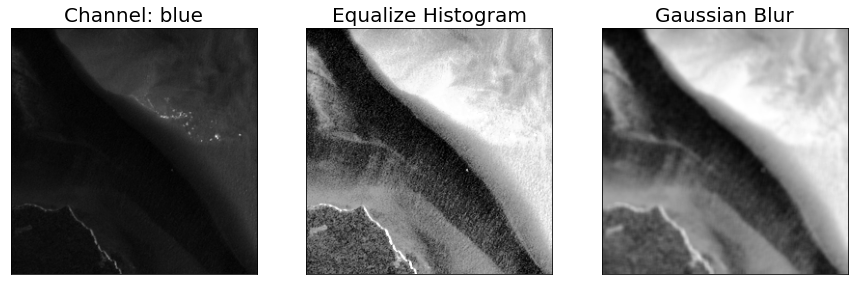

In [300]:
rint = random.randint(0,98)
fig, axs = plt.subplots(1,3, figsize=(15,15))
print(rint)
rint = 2

#Get blue channel
img = channel_filter(input[rint],c=1)

# Original
axs[0].imshow(img,cmap="gray")
axs[0].set_title("Channel: blue",size=20)

# Scale bands between 0 and 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img = np.uint8(img)

# Histogram Equalization
img = cv2.equalizeHist(img)
axs[1].imshow(img,cmap="gray")
axs[1].set_title("Equalize Histogram",size=20)

# Gaussian Blur
kernel = (5,5)
img = cv2.GaussianBlur(img, kernel,cv2.BORDER_DEFAULT)
axs[2].imshow(img,cmap="gray")
axs[2].set_title("Gaussian Blur",size=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("preprocessing.png"),bbox_inches='tight')

72


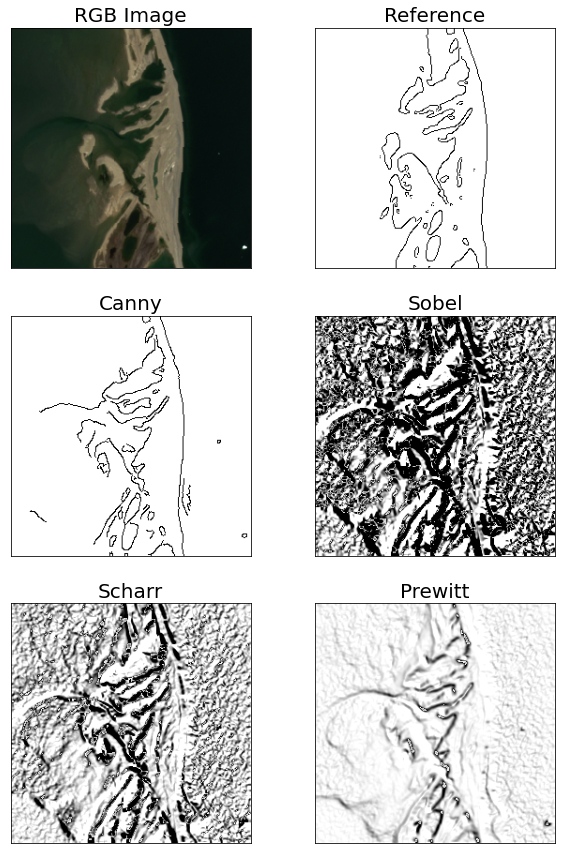

In [351]:
rint = random.randint(0,98)
fig, axs = plt.subplots(3,2, figsize=(10,15))
print(rint)
rint = 7

channel = 1

axs[0,0].imshow(rgb[rint])
axs[0,0].set_title("RGB Image",size=20)

axs[0,1].imshow(255-edge_reference[rint],cmap="gray")
axs[0,1].set_title("Reference",size=20)

axs[1,0].imshow(255-canny[rint][:,:,channel],cmap="gray")
axs[1,0].set_title("Canny",size=20)

axs[1,1].imshow(255-sobel[rint][:,:,channel],cmap="gray")
axs[1,1].set_title("Sobel",size=20)

axs[2,0].imshow(255-scharr[rint][:,:,channel],cmap="gray")
axs[2,0].set_title("Scharr",size=20)

axs[2,1].imshow(255-prewitt[rint][:,:,channel],cmap="gray")
axs[2,1].set_title("Prewitt",size=20)

for ax1 in axs:
    for ax in ax1:
        ax.set_xticks([])
        ax.set_yticks([])

plt.savefig(save_path.format("edge_detection.png"),bbox_inches='tight')

0


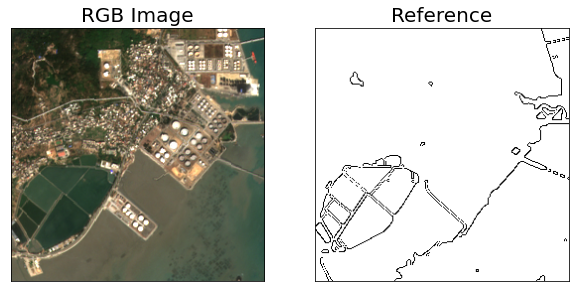

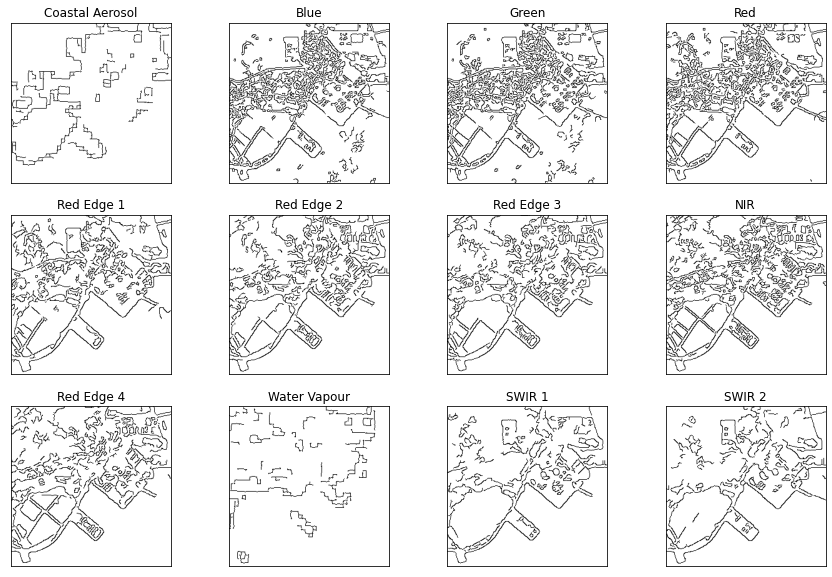

In [460]:
# Canny Edge Detection all channels
preprocess_input = input.copy()
preprocess_input = [preprocess(img,toggle=[True,True,False]) for img in preprocess_input]

canny = [canny_ed(img) for img in preprocess_input]
scharr = [scharr_ed(img) for img in preprocess_input]
sobel = [sobel_ed(img) for img in preprocess_input]
prewitt = [prewitt_ed(img) for img in preprocess_input]


rint = random.randint(0,98)
fig, axs = plt.subplots(1,2, figsize=(10,15))
print(rint)

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB Image",size=20)

axs[1].imshow(255-edge_reference[rint],cmap="gray")
axs[1].set_title("Reference",size=20)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("details.png"),bbox_inches='tight')

plot_channels(canny[rint],invert=True)



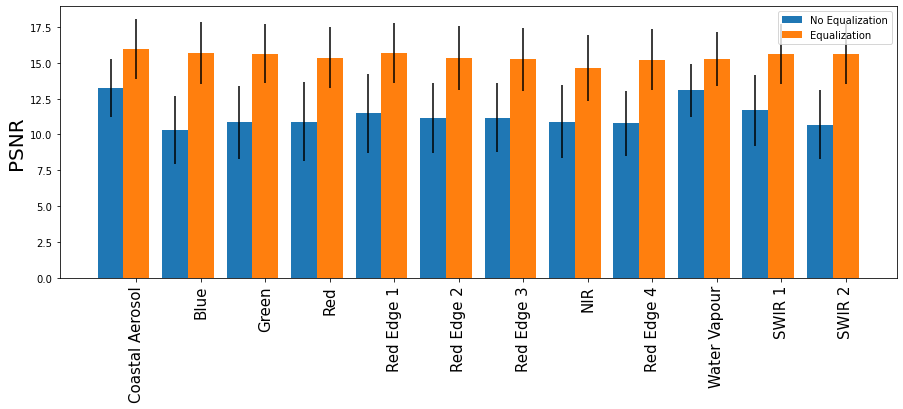

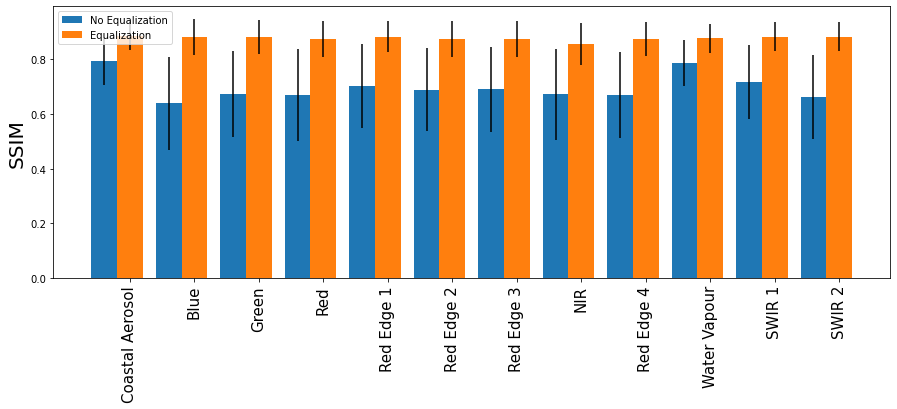

In [454]:
# Compare histogram equalization vs no equalization
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)
df_blur = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_blur.csv",index_col=0)
df_morph = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv",index_col=0)

mean_all = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_all = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_blur = df_blur[df_blur.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_blur = df_blur[df_blur.method=='canny'].groupby(["method","band"],as_index=False).std()


bands = mean_all['band']

w= 0.8
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_all[metric],yerr=sd_all[metric],width=w/2,label='No Equalization')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Equalization')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()
plt.savefig(save_path.format("equalization_effect.png"),bbox_inches='tight')

w= 0.8
metric = 'ssim'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_all[metric],yerr=sd_all[metric],width=w/2,label='No Equalization')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Equalization')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()

81


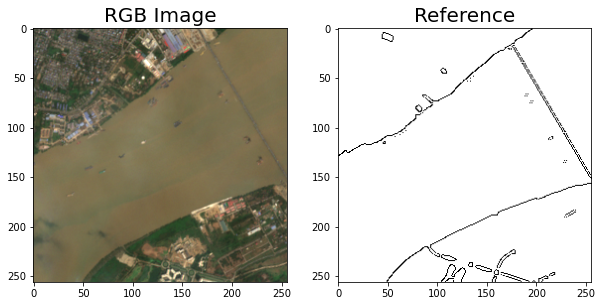

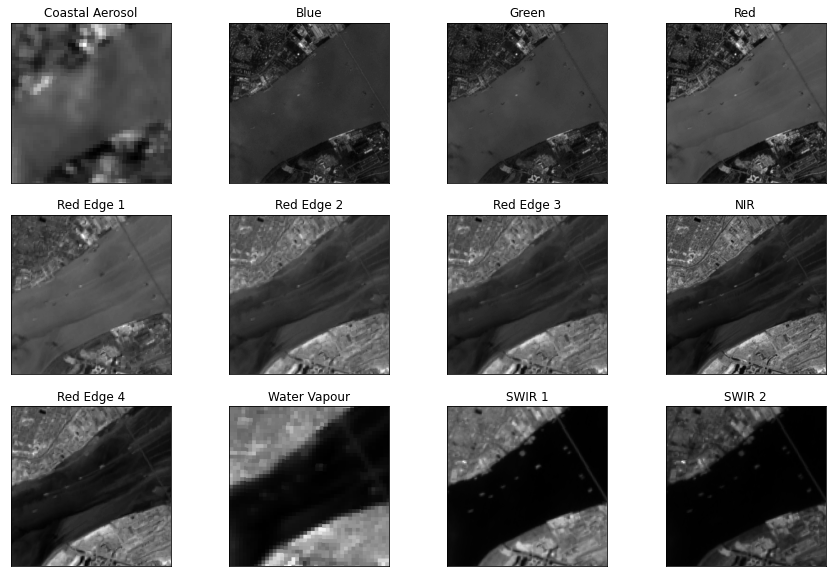

In [416]:
rint = random.randint(0,98)
fig, axs = plt.subplots(1,2, figsize=(10,15))
print(rint)

axs[0].imshow(rgb[rint])
axs[0].set_title("RGB Image",size=20)

axs[1].imshow(255-edge_reference[rint],cmap="gray")
axs[1].set_title("Reference",size=20)


plot_channels(input[rint])

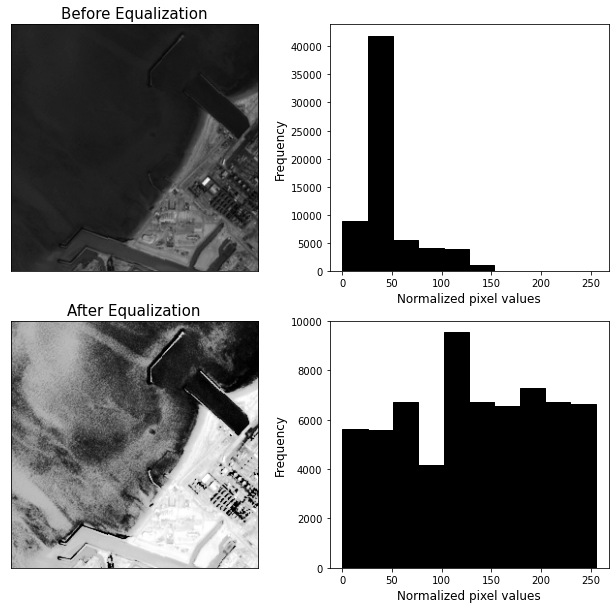

In [428]:
fig, axs = plt.subplots(2,2, figsize=(11,10))
rint= 60

#Before equalization
blue = channel_filter(input[rint],1)
blue = cv2.normalize(blue, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
axs[0,0].imshow(blue,cmap="gray")

axs[0,0].set_xticks([])
axs[0,0].set_yticks([])
axs[0,0].set_title("Before Equalization",size=15)

axs[0,1].hist(blue.ravel(), fc='k', ec='k')
axs[0,1].set_xlabel("Normalized pixel values",size=12)
axs[0,1].set_ylabel("Frequency",size=12)

#After equalization
blue_hist = cv2.equalizeHist(blue)
axs[1,0].imshow(blue_hist,cmap="gray")
axs[1,0].set_xticks([])
axs[1,0].set_yticks([])
axs[1,0].set_title("After Equalization",size=15)

axs[1,1].hist(blue_hist.ravel(), fc='k', ec='k')
axs[1,1].set_xlabel("Normalized pixel values",size=12)
axs[1,1].set_ylabel("Frequency",size=12)

plt.savefig(save_path.format("histogram_equalization.png"),bbox_inches='tight')

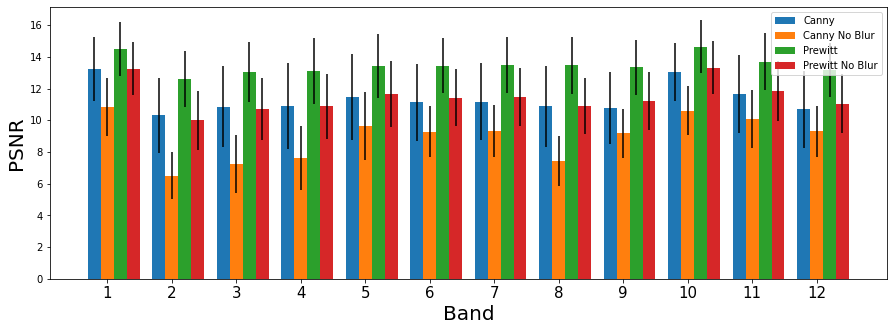

In [383]:
# Determin impact of bluring on edge detection
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0)
df_hist = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv",index_col=0)

mean_canny = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_canny = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_canny_noblur = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_canny_noblur = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_prewitt = df_all[df_all.method=='prewitt'].groupby(["method","band"],as_index=False).mean()
sd_prewitt = df_all[df_all.method=='prewitt'].groupby(["method","band"],as_index=False).std()

mean_prewitt_noblur = df_hist[df_hist.method=='prewitt'].groupby(["method","band"],as_index=False).mean()
sd_prewitt_noblur = df_hist[df_hist.method=='prewitt'].groupby(["method","band"],as_index=False).std()

bands = mean_canny['band']

w= 0.4
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_canny[metric],yerr=sd_canny[metric],width=w/2,label='Canny')
plt.bar(bands,mean_canny_noblur[metric],yerr=sd_canny_noblur[metric],width=w/2,label='Canny No Blur')
plt.bar(bands+w/2,mean_prewitt[metric],yerr=sd_prewitt[metric],width=w/2,label='Prewitt')
plt.bar(bands+w,mean_prewitt_noblur[metric],yerr=sd_prewitt_noblur[metric],width=w/2,label='Prewitt No Blur')

plt.ylabel(metric.upper(),fontsize=20)
plt.xlabel("Band",fontsize=20)
plt.xticks(range(1,13),fontsize=15)

plt.legend()

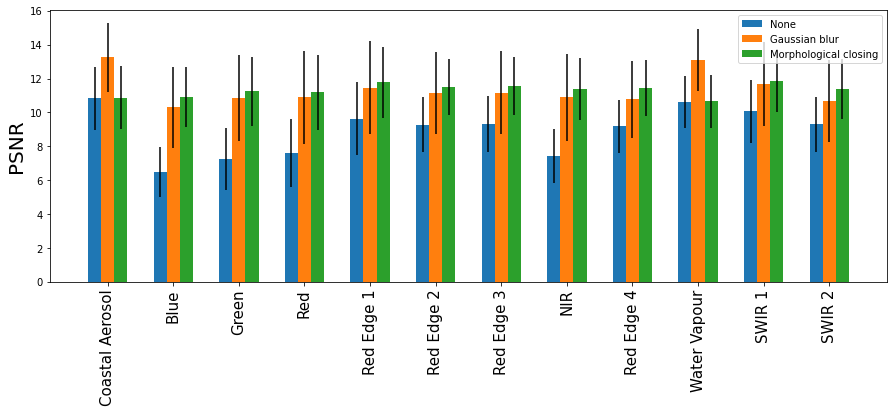

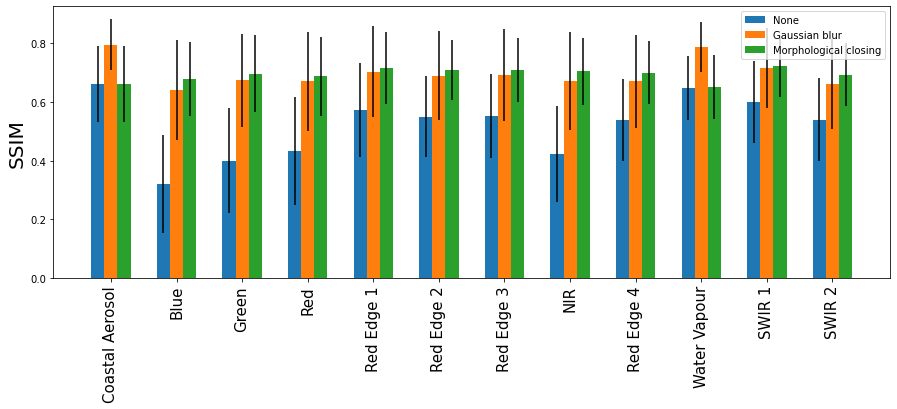

In [461]:
# Determin impact of post processing
df_hist = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_hist.csv",index_col=0) #no noise reduction
df_all = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_all.csv",index_col=0) #blur
df_morph = pd.read_csv("/Users/conorosullivan/Google Drive/My Drive/UCD/research/SWED/Metrics_morph.csv",index_col=0) #morph



mean_none = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_none = df_hist[df_hist.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_blur = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_blur = df_all[df_all.method=='canny'].groupby(["method","band"],as_index=False).std()

mean_morph = df_morph[df_morph.method=='canny'].groupby(["method","band"],as_index=False).mean()
sd_morph = df_morph[df_morph.method=='canny'].groupby(["method","band"],as_index=False).std()

bands = mean_canny['band']

w= 0.4
metric = 'psnr'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_none[metric],yerr=sd_none[metric],width=w/2,label='None')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Gaussian blur')
plt.bar(bands+w/2,mean_morph[metric],yerr=sd_morph[metric],width=w/2,label='Morphological closing')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()

plt.savefig(save_path.format("effect_processing.png"),bbox_inches='tight')

w= 0.4
metric = 'ssim'
fig,ax = plt.subplots(1,1,figsize=(15,5))
plt.bar(bands-w/2,mean_none[metric],yerr=sd_none[metric],width=w/2,label='None')
plt.bar(bands,mean_blur[metric],yerr=sd_blur[metric],width=w/2,label='Gaussian blur')
plt.bar(bands+w/2,mean_morph[metric],yerr=sd_morph[metric],width=w/2,label='Morphological closing')

plt.ylabel(metric.upper(),fontsize=20)
plt.xticks(ticks=range(1,13),labels= channels,fontsize=15, rotation=90)

plt.legend()

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

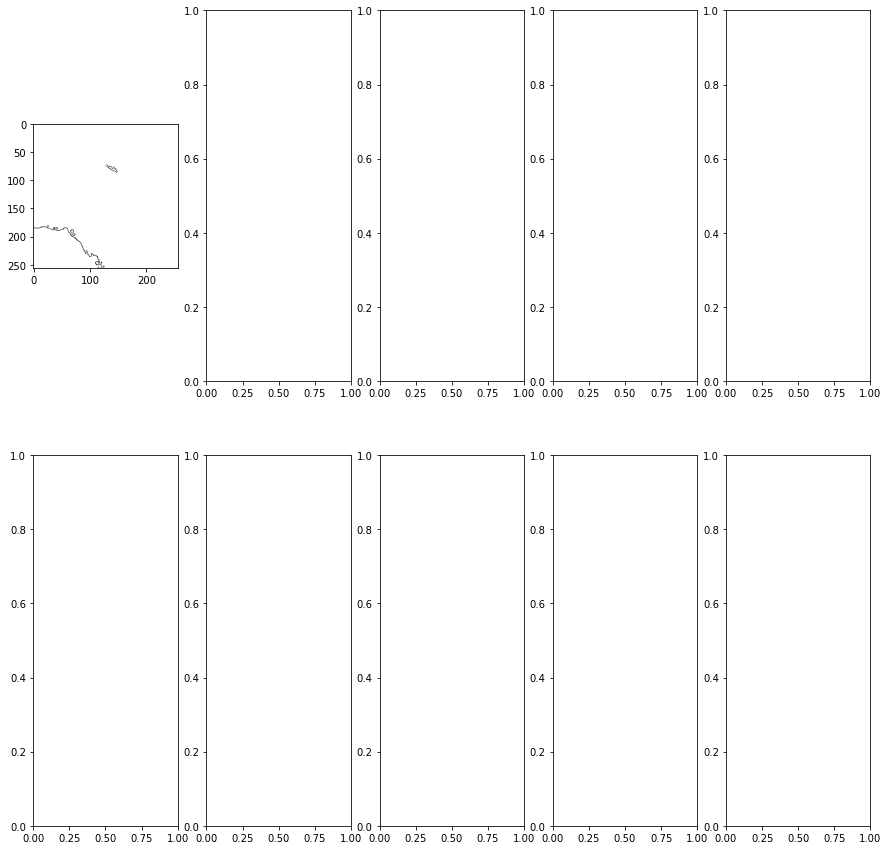

In [10]:
fig, axs = plt.subplots(2,5, figsize=(15,15))
rint = 2

#Get blue channel
img = channel_filter(input[rint],c=1)


# Original
axs[0,0].imshow(255-edge_reference[rint],cmap="gray")
axs[0].set_title("Edge Reference",size=20)

# Scale bands between 0 and 255
img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
img = np.uint8(img)

# Histogram Equalization
img = cv2.equalizeHist(img)
axs[1].imshow(img,cmap="gray")
axs[1].set_title("Equalize Histogram",size=20)

# Gaussian Blur
kernel = (5,5)
img = cv2.GaussianBlur(img, kernel,cv2.BORDER_DEFAULT)
axs[2].imshow(img,cmap="gray")
axs[2].set_title("Gaussian Blur",size=20)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.savefig(save_path.format("preprocessing.png"),bbox_inches='tight')